In [ ]:
#| default_exp reader 

# Reading UPLC-PDA data 

> Getting started 

In [ ]:
#|hide 
%load_ext autoreload
%autoreload 2 

In [ ]:
#| hide 
import os
import matplotlib.pyplot as plt 

As a very first step we need to read the PDA data from file. Thermo Chromeleon software can export this type of data to a text file that contains a header and a data block. All values are separated with tab characters. To read the data from the text file, import the function `read_pda()`.  

In [ ]:
from rainbowmaker import read_pda

In [ ]:
indir = '/home/frank/Work/Projecten/Revigo/data/benzylviolet-PDA-export' 
os.chdir(indir)

In [ ]:
pda_filename = 'Sanne-Export-3d-data-Benzyl-violet_2022-11-28.txt' 

header, nms, times, pda_data = read_pda(pda_filename)

In [ ]:
print(header)

File Path	chrom://chromeleon/REL_DATA/Aanvragen/2018/2018-096 Benzyl violet/2022 juni.seq/576.smp/DAD1_Spectrum.field
Spectral Field	DAD1_Spectrum

Injection Information:
Data Vault	REL_DATA
Injection	pos 70NCE 
Injection Number	3
Position	Vial:31
Comment	
Processing Method	Quantitative PDA 3.0
Instrument Method	AFFA 68.50min ddMS2 pos 70NCE
Type	Unknown
Status	Finished
Injection Date	21/06/2022
Injection Time	09:37:16
Injection Volume (µL)	1.00
Dilution Factor	1.0000
Weight	1.0000

Raw Data Information:
Time Min. (min)	0.000167
Time Max. (min)	68.498500
Scan Min. (nm)	190.000000
Scan Max. (nm)	640.000000
Signal Min. (mAU)	-98.869449
Signal Max. (mAU)	1,970.848559
Spectra	82199
Detector	DAD1
Detector Type	UV
Generating Data System	Chromeleon 7.2.9 Build 11323 (300176)
Exporting Data System	Chromeleon 7.2.9.0
Spectral Field	DAD1_Spectrum
Driver Name	Agilent.IcfAdapter.Chromeleon.DdkIcfCore.dll

Raw Data:



And here is a plot of the data. 

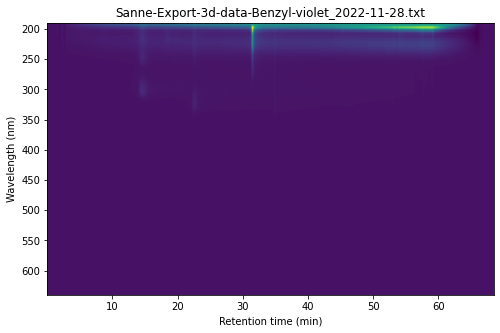

In [ ]:
extent = [times[0], times[-1], nms[-1], nms[0]]

fig, ax = plt.subplots(figsize=[8, 5])
ax.imshow(pda_data.T, aspect='auto', extent=extent)
ax.set_xlabel('Retention time (min)')
ax.set_ylabel('Wavelength (nm)')
ax.set_title(pda_filename); 

In [ ]:
#| export 

import re 
import numpy as np  


In [ ]:
#| export 

def read_pda(filename, sep='\t', encoding='utf-8-sig', thousand_sep=','): 
    '''Read Thermo PDA text file. 
    
    Returns: header, nms, times, pda_data 
    '''
    
    # add encoding to skip Byte Order Mark (BOM) in first line  
    # https://stackoverflow.com/questions/17912307/u-ufeff-in-python-string  

    with open(filename, 'r', encoding=encoding) as fh: 
        lines = fh.readlines()
            
    # header block should contains less columns then data block 
    # find maximum number of columns 
    ncols_list = []

    for i, line in enumerate(lines): 

        ncols = len(re.split('\t', line))
        ncols_list.append(ncols)

    ncols_list = np.array(ncols_list)

    ncols = max(ncols_list)

    is_data = ncols_list == ncols
    
    # split lines into header, nms line and data lines 
    header_lines = np.array(lines)[~is_data]
    header = ''.join(header_lines)

    nms_line = np.array(lines)[is_data][0]
    data_lines = np.array(lines)[is_data][1:]
    n_datarows = len(data_lines) 
    
    # find wavelength columns 
    
    # remove stupid thousand separator 
    nms_line = re.sub(thousand_sep, '', nms_line)  
    
    # split nms_line and select numerical column headers with nm values 
    
    names = re.split('\t', nms_line) # Time (min)\tIntegr.Time (s)\t190.0\t195.0 ... \t640.0
    num_ptrn = re.compile('^\s*\d+\.*\d*\s*$')
    is_num = [bool(num_ptrn.match(i)) for i in names]

    nms = np.array(names)[is_num].astype(float) 
    n_datacols = len(nms) 

    # initialize arrays 
    pda_data = np.zeros([n_datarows, n_datacols])
    times = np.zeros([n_datarows])

    # parse data lines 

    for i, line in enumerate(data_lines): 

        #print(f'Parsing line: {i}', end='\r')

        # remove all stupid thousand separator commas to allow conversion to floats
        line = re.sub(thousand_sep, '', line) 

        values = np.array(re.split('\t', line))

        pda_data[i] = values[is_num].astype(float)
        times[i] = values[0].astype(float)
      
    return header, nms, times, pda_data